In [1]:
!pip install beautifulsoup4
!pip install selenium
!pip install unidecode
!pip install --upgrade gensim
!pip install PyPDF2
!pip install pyLDAvis==2.1.2
!pip install -U spacy
!python -m spacy download pt_core_news_sm
!pip install "tqdm>=4.9.0"

You should consider upgrading via the 'C:\Users\agfer\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\agfer\anaconda3\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\agfer\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\agfer\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\agfer\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\agfer\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\agfer\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


2021-09-04 01:07:11.611365: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2021-09-04 01:07:11.611419: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
You should consider upgrading via the 'C:\Users\agfer\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\agfer\anaconda3\python.exe -m pip install --upgrade pip' command.


### Mapeamento para bibliotecas e arquivo SQLite

In [ ]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

sys.path.append('/content/drive/My Drive/document_similarity')
dir_path = "/content/drive/My Drive/document_similarity"
os.chdir(dir_path)

### Chromedriver

In [ ]:
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

### Scraping de normas do CMN

Realiza a busca de normativos no site do Banco central - https://www.bcb.gov.br/estabilidadefinanceira/buscanormas. Cada documento encontrado é adicionado a um banco de dados SQLite para consulta mais rápida posteriormente. A pesquisa de normativos permite filtragem por data, após processar todos os documentos de um dado intervalo de datas, é gravada a última data do intervalor processado com sucesso no banco de dados. Caso ocorra algum erro no scraping, o próximo intervalor começará a partir da última data processada com sucesso

In [5]:
from lib.BuscaNormativoBacen import BuscaNormativoBacen
from lib.ResolucaoCMN import ResolucaoCMN
from lib.database import Norm, Control, DB, DocumentType
from lib.DateUtils import toBrazilianDate, fromBrazilianDate, today, now, addMonths, addDays

db = DB()

#Inicializando busca de normativos
start_date = Control.find_last_date_processed(db.session(), DocumentType.CMN) or fromBrazilianDate('01/01/2000')
end_date = addMonths(start_date, 12)

busca = BuscaNormativoBacen()
busca.load()
busca.pesquisar(toBrazilianDate(start_date), toBrazilianDate(end_date))

# Busca novas faixas de datas
while True:
    process_start_time = now()
    print(f'Buscando normativos entre {toBrazilianDate(start_date)} e {toBrazilianDate(end_date)}')

    # Busca dentro dos resultados em um determinada faixa
    while True:
        results = busca.get_results()

        for result in results:
            norm = Norm.find_by_url(db.session(), result)
            if norm and norm.processing_date:
                print('Normativo já processado')
                continue
              
            try:
                html = busca.resolucao_source(result)
                resolucao = ResolucaoCMN()
                content = resolucao.get_text(html)
                
                if norm:
                    norm.content=content['text']
                    norm.processing_date = now()
                else:
                    norm = Norm(type=DocumentType.CMN, 
                                url=result, 
                                title=content['title'], 
                                content=content['text'], 
                                processing_date=now())
                    db.add(norm)

            except Exception:
                  Norm(type=DocumentType.CMN, url=result)

        busca.load()     
        if busca.has_next_result_page():
            print('Buscando proxima página')
            busca.next_result_page()
        else:
            break
              
    last_date_processed = end_date if end_date < today() else today()
    control = Control(type=DocumentType.CMN, start_time=process_start_time, finish_time=now(), last_date_processed=last_date_processed)
    db.add(control)

    start_date = addDays(end_date, 1)

    if start_date > today():
        print('Não há mais normativos a serem incluídos na busca')
        break

    end_date = addMonths(start_date, 12)
    busca.pesquisar(toBrazilianDate(start_date), toBrazilianDate(end_date))
    results = busca.get_results()
        
db.close()
busca.close()

Buscando normativos entre 20/04/2021 e 15/04/2022
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Buscando proxima página
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Buscando proxima página
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já processado
Normativo já p

### Scraping dados BNDES

Realiza busca de normativos de operações indiretas no site do BNDES - https://www.bndes.gov.br/wps/portal/site/home/instituicoes-financeiras-credenciadas/normas/normas-operacoes-indiretas . Cada documento PDF encontrado é convertido e gravado no banco de dados para consulta mais rápida posteriormente.

In [6]:
from lib.BuscaNormativoBNDES import BuscaNormativoBNDES
from lib.TextUtils import text_from_pdf
from lib.database import Norm, Control, DB, DocumentType
from lib.DateUtils import now

busca = BuscaNormativoBNDES()
busca.load()

db = DB()

process_start_time = now()

while True:
    results = busca.get_results()
    new_docs = 0
    old_docs = 0
    
    for result in results:
        norm = Norm.find_by_url(db.session(), result['url'])
        if norm and norm.processing_date:
            old_docs += 1
            continue
        new_docs += 1

        try:
            content = text_from_pdf(result['url'])

            if norm:
                norm.content=content
                norm.processing_date = now()
            else:
                norm = Norm(type=DocumentType.BNDES, 
                            url=result['url'], 
                            title=result['title'], 
                            content=content, 
                            processing_date=now())
                db.add(norm)

        except Exception:
              print(f'Falha ao processar {result["url"]}')
              Norm(type=DocumentType.BNDES, url=result['url'])

    print(f'Encontrados {new_docs} novos documentos e {old_docs} já processados')
                    
    if busca.has_next_result_page():
        print('Buscando proxima página')
        busca.next_result_page()
    else:
        break
        
control = Control(type=DocumentType.BNDES, start_time=process_start_time, finish_time=now())
db.add(control)

db.close()
busca.close()

Falha ao processar https://www.bndes.gov.br/wps/wcm/connect/site/d5c14726-1f29-4ffe-b404-1e63adb44584/21avadig21+Suspens%C3%A3o+ABC+Demais+Finalidades%2C+Moderfrota+e+Pronaf+Tratores+e+Colheitadeiras.doc?MOD=AJPERES&CACHEID=ROOTWORKSPACE.Z18_7QGCHA41LORVA0AHO1SIO51085-d5c14726-1f29-4ffe-b404-1e63adb44584-nG6G2qE
Falha ao processar https://www.bndes.gov.br/wps/wcm/connect/site/e1163469-c271-4122-bf21-ef6e0ef69ab2/21avadig20+Suspens%C3%A3o+Inovagro+e+Pronaf+Inv.+Faixa+1.doc?MOD=AJPERES&CACHEID=ROOTWORKSPACE.Z18_7QGCHA41LORVA0AHO1SIO51085-e1163469-c271-4122-bf21-ef6e0ef69ab2-nG6FX71
Falha ao processar https://www.bndes.gov.br/wps/wcm/connect/site/84efbb55-8444-43e2-b09b-762cf1991ed9/21Cir20+Programa+Fundo+Clima.doc?MOD=AJPERES&CACHEID=ROOTWORKSPACE.Z18_7QGCHA41LORVA0AHO1SIO51085-84efbb55-8444-43e2-b09b-762cf1991ed9-nG6FRWa
Falha ao processar https://www.bndes.gov.br/wps/wcm/connect/site/55627170-ea8e-4999-a381-25acb0154ae6/21avadig14+Informa%C3%A7%C3%A3o+da+ROB.doc?MOD=AJPERES&CACHEID=ROO

### Dados do dataset

Recuperando os dados do Banco Central e do BNDES gravados no banco de dados SQLite. É feito tratamento do texto, removendo stop words, realizando lemmatização e removendo caracteres especiais. Também é gravada a informação do texto com bigramas e trigramas.

In [24]:
from lib.database import Norm, DB, DocumentType
import pandas as pd
from lib.TextUtils import trigrams, preprocess
from tqdm import tqdm

db = DB()
normas = db.session().query(Norm).all()
db.close()

normas_dict = {
    'id': (n.id for n in normas),
    'type': (n.type for n in normas),
    'url': (n.url for n in normas),
    'title': (n.title for n in normas),
    'content': (n.content for n in normas)
}

df_normas = pd.DataFrame(normas_dict)
# Remove stopwords, obtém lemma, remove acentuação e altera para apenas letras minúsculas

tqdm.pandas(desc="preprocessing")
df_normas['preprocessed'] = df_normas.progress_apply(lambda row: preprocess(row.content), axis=1)

tqdm.pandas(desc="trigrams")
tgm_model = trigrams(df_normas['preprocessed'])
df_normas['trigrams'] = df_normas.progress_apply(lambda row: tgm_model[row.preprocessed], axis=1)

tgm_model.save('trigram.phrase')
df_normas.to_pickle('df_normas.pickle')

C:\Users\agfer\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
trigrams: 100%|██████████████████████████████████████████████████████████████████| 2978/2978 [00:02<00:00, 1133.73it/s]


In [29]:
from nltk import Counter

df_normas = pd.read_pickle('df_normas.pickle')

counter_preprocessed = Counter()

for word in df_normas['preprocessed']:
    counter_preprocessed.update(word)

df_normas['preprocessed_truncated'] = df_normas.apply(lambda row: [token for token in row['preprocessed'] if counter_preprocessed[token] > 3], axis=1)
df_normas['content_length'] = df_normas.apply(lambda row: len(row.preprocessed_truncated), axis=1)

counter_trigrams = Counter()

for word in df_normas['trigrams']:
    counter_trigrams.update(word)
    
df_normas['trigrams_truncated'] =  df_normas.apply(lambda row: [token for token in row.trigrams if counter_trigrams[token] > 3], axis=1)
df_normas.to_pickle('df_normas.pickle')

In [17]:
import pandas as pd

df_normas = pd.read_pickle('df_normas.pickle')

df_cmn = df_normas[df_normas['type'] == DocumentType.CMN]
df_bndes = df_normas[df_normas['type'] == DocumentType.BNDES]

Verificando os dados recuperados.

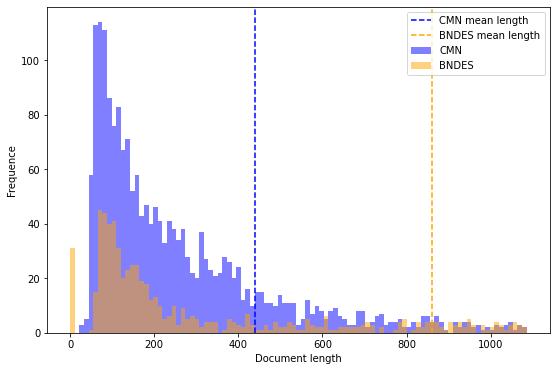

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [9, 6]

bins = np.linspace(min(df_cmn['content_length'].min(), df_bndes['content_length'].min()),
                   max(df_cmn['content_length'].quantile(0.75), df_bndes['content_length'].quantile(0.75)), 100)

plt.hist(df_cmn['content_length'], bins=bins, alpha = 0.5, color= 'blue', label='CMN')
plt.axvline(df_cmn['content_length'].mean(), ls='--', label='CMN mean length', color='blue')

plt.hist(df_bndes['content_length'], bins=bins, alpha = 0.5, color= 'orange', label='BNDES')
plt.axvline(df_bndes['content_length'].mean(), ls='--', label='BNDES mean length', color='orange')

plt.xlabel('Document length');
plt.ylabel('Frequence');
plt.legend()

Verificando os termos mais comuns.

In [38]:
counter_trigrams = Counter()

for word in df_normas['trigrams_truncated']:
    counter_trigrams.update(word)
    
counter_trigrams.most_common(50)

[('ser', 25011),
 ('operacao', 23837),
 ('bndes', 22280),
 ('credito', 17818),
 ('dever', 15372),
 ('financiamento', 14814),
 ('instituicao', 12394),
 ('observar', 9078),
 ('financeiro', 9056),
 ('item', 8884),
 ('programar', 8671),
 ('ano', 8546),
 ('cento', 8209),
 ('tratar', 8010),
 ('brasil', 7863),
 ('poder', 7420),
 ('banco_central', 7169),
 ('casar', 7064),
 ('condicao', 6944),
 ('valor', 6868),
 ('recurso', 6833),
 ('produto', 6731),
 ('investimento', 6372),
 ('contratar', 6334),
 ('rural', 6107),
 ('datar', 5892),
 ('dispor', 5293),
 ('seguinte', 4951),
 ('beneficiario', 4876),
 ('prazo', 4835),
 ('referir', 4795),
 ('limitar', 4531),
 ('agente_financeiro', 4396),
 ('conformar', 4282),
 ('mcr', 4278),
 ('sistema', 4199),
 ('ambito', 4149),
 ('cada', 3912),
 ('estabelecido', 3891),
 ('previsto', 3851),
 ('devir', 3831),
 ('partir', 3750),
 ('mes', 3725),
 ('realizar', 3643),
 ('cooperativo', 3541),
 ('financeiro_credenciado', 3537),
 ('bem', 3333),
 ('formar', 3264),
 ('contrat

### LDA

Modelando os tópicos da base da dados de normativos. São gerados modelos com 10, 15, 20 e 25 tópicos. Selecionamos o modelo que será utilizado verificando o coherence score de cada um dos modelos.

In [52]:
from gensim import corpora
from gensim.models import ldamodel
from gensim.models.coherencemodel import CoherenceModel

dictionary = corpora.Dictionary(df_normas['trigrams_truncated'])
dictionary.filter_extremes(no_below=20, no_above=0.2)

corpus = [dictionary.doc2bow(text) for text in df_normas['trigrams_truncated']] 

chunksize = 2000
passes = 40
iterations = 500

num_topics = []
lda_models = []
coherence_scores = []

for i in range(10, 26, 5): 
    lda_model = ldamodel.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=i,
        passes=passes
    )
    
    coherencemodel = CoherenceModel(model=lda_model, texts=df_normas['trigrams_truncated'], dictionary=dictionary, coherence='c_v')
    
    num_topics.append(i)
    lda_models.append(lda_model)
    coherence_scores.append(coherencemodel.get_coherence())

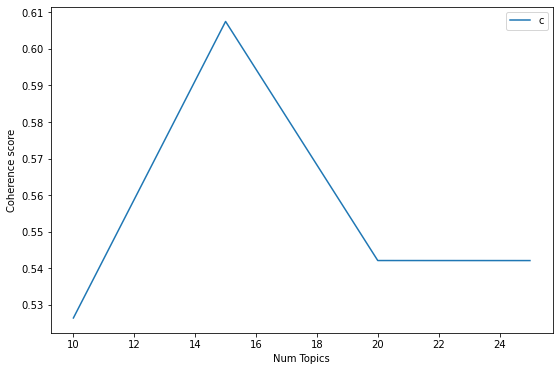

In [53]:
import matplotlib.pyplot as plt

plt.plot(num_topics, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Selecionando o modelo com o melhor coherence score

In [54]:
max_score = max(coherence_scores)
max_index = coherence_scores.index(max_score)

dictionary.save('doc_similarity.dictionary')
corpora.MmCorpus.serialize('doc_similarity.corpus', corpus)
lda_models[max_index].save('doc_similarity.lda.model')

Verificando os tópicos

In [55]:
from gensim import corpora
from gensim.models import ldamodel

dictionary = corpora.Dictionary.load('doc_similarity.dictionary')
corpus = corpora.MmCorpus('doc_similarity.corpus')
lda_model = ldamodel.LdaModel.load('doc_similarity.lda.model')
lda_model.show_topics()

[(8,
  '0.026*"proagro" + 0.025*"empreendimento" + 0.021*"agente" + 0.013*"garantir_atividade" + 0.012*"agropecuario_proagro" + 0.012*"area" + 0.011*"enquadrar" + 0.011*"cobertura" + 0.011*"lavourar" + 0.011*"titulo"'),
 (0,
  '0.037*"pronaf" + 0.022*"agricultura_familiar" + 0.021*"nacional_fortalecimento" + 0.017*"custear" + 0.015*"agricultor_familiar" + 0.015*"mil_real" + 0.014*"mutuario" + 0.014*"grupar" + 0.011*"familiar" + 0.009*"reformar_agrario"'),
 (10,
  '0.025*"mobiliario" + 0.023*"emissor" + 0.017*"cartao" + 0.016*"acoes" + 0.016*"paragrafo" + 0.015*"comissao_valorar" + 0.015*"ativos" + 0.014*"cotar_fundo" + 0.013*"fundo_investimento" + 0.012*"carteiro"'),
 (6,
  '0.015*"producao_agropecuario" + 0.014*"area" + 0.013*"programar_incentivar" + 0.012*"ano_agricola" + 0.011*"projeto" + 0.011*"implemento_associar" + 0.010*"programar_abc" + 0.010*"taxar_efetiva" + 0.010*"tratores_agricola" + 0.009*"tesourar_nacional"'),
 (1,
  '0.021*"linha" + 0.019*"pronaf" + 0.016*"producao" + 0.

In [56]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_models[1], corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.183021 -0.042040       1        1  11.816660
5      0.173573 -0.211182       2        1  10.042796
4      0.011351 -0.110320       3        1   9.415884
2     -0.202941  0.058036       4        1   7.945532
14     0.078301  0.172731       5        1   7.485357
1      0.205327  0.068779       6        1   7.048869
13     0.062211 -0.230782       7        1   6.409518
0      0.136721  0.169524       8        1   5.965576
12     0.019970  0.147583       9        1   5.949623
10    -0.229655  0.034127      10        1   5.609977
9     -0.027705 -0.024543      11        1   5.431123
8     -0.035275  0.089318      12        1   5.100051
11    -0.238630  0.037157      13        1   4.751284
6      0.224504  0.103022      14        1   3.749152
7      0.005268 -0.261410      15        1   3.278600, topic_info=                        Term         Freq        Total Category  logprob  \
2643  financeiro_credenciado  3964.000000  3964.000000  Default  30.0000   
3539                 subitem  2296.000000  2296.000000  Default  29.0000   
812                   finame  2146.000000  2146.000000  Default  28.0000   
2309      beneficiario_final  2921.000000  2921.000000  Default  27.0000   
1588              automatico  3080.000000  3080.000000  Default  26.0000   
...                      ...          ...          ...      ...      ...   
1214                    area   212.522781  1479.144409  Topic15  -4.5552   
106                   seguir   214.113525  1702.668701  Topic15  -4.5477   
3253               protocolo   183.735687   878.440796  Topic15  -4.7008   
606                enquadrar   188.708954  1294.725342  Topic15  -4.6740   
511                 empresar   179.400314  1328.874512  Topic15  -4.7246   

      loglift  
2643  30.0000  
3539  29.0000  
812   28.0000  
2309  27.0000  
1588  26.0000  
...       ...  
1214   1.4776  
106    1.3443  
3253   1.8531  
606    1.4919  
511    1.4153  

[985 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
3143     11  0.990887   abastecimento_mapa
1731      2  0.006803     abrangencia_todo
1731      6  0.244907     abrangencia_todo
1731     14  0.741523     abrangencia_todo
3402     15  0.977896           aceleracao
...     ...       ...                  ...
2651      3  0.110027           zoneamento
2651     12  0.843539           zoneamento
2651     14  0.036676           zoneamento
1730     12  0.968280  zoneamento_agricola
1730     14  0.022006  zoneamento_agricola

[2915 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 5, 3, 15, 2, 14, 1, 13, 11, 10, 9, 12, 7, 8])

### TF-IDF

Criando modelo TF-IDF (Term Frequency – Inverse Document Frequency)

In [9]:
from gensim import corpora, similarities
from gensim.models import ldamodel, TfidfModel

dictionary = corpora.Dictionary.load('doc_similarity.dictionary')
corpus = corpora.MmCorpus('doc_similarity.corpus')

tfidf = TfidfModel(corpus)
tfidf.save('doc_similarity.tfidf.model')

### Doc2Vec

Criando modelo Doc2Vec. Serão criados modelos utilizando tanto o texto completo, quanto modelos limitando o tamanho total de tokens. Posteriormente avaliaremos qual modelo obteve os melhores resultados nos documentos de teste.

In [45]:
from gensim.models.callbacks import CallbackAny2Vec
import tensorflow as tf

class Doc2VecCallback(CallbackAny2Vec):
    def __init__(self, epochs):
        self.prog_bar = tf.keras.utils.Progbar(epochs)
        self.epoch = 0
    def on_epoch_end(self, model):
        self.epoch += 1
        self.prog_bar.update(self.epoch)

In [148]:
import os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing

def generate_models(serie, window_sizes=[5], vector_sizes=[30, 50, 100, 200, 300], epochs=50):
    CORES = multiprocessing.cpu_count()

    documents = []
    for i, item in serie.items():
            documents.append(TaggedDocument(words=item, tags=[i]))

    for window_size in window_sizes:
        for vector_size in vector_sizes:
            print(f'Treinando modelo com janela de tamanho {window_size} e vetor de tamanho {vector_size}')

            model = Doc2Vec(documents, vector_size=vector_size, window=window_size, min_count=2, workers=CORES, epochs=epochs, callbacks=[Doc2VecCallback(epochs)])
            model.train(documents, total_examples=model.corpus_count, epochs=epochs, callbacks=[Doc2VecCallback(epochs)])
            model.save(f'docsim_w{window_size}_v{vector_size}.doc2vec')

In [149]:
generate_models(df_normas['preprocessed_truncated'])

Treinando modelo com janela de tamanho 5 e vetor de tamanho 30
50/50 [==============================] - 65s 1s/step
Treinando modelo com janela de tamanho 5 e vetor de tamanho 50
50/50 [==============================] - 53s 1s/step
Treinando modelo com janela de tamanho 5 e vetor de tamanho 100
50/50 [==============================] - 64s 1s/step
Treinando modelo com janela de tamanho 5 e vetor de tamanho 200
50/50 [==============================] - 63s 1s/step
Treinando modelo com janela de tamanho 5 e vetor de tamanho 300
50/50 [==============================] - 70s 1s/step


Verificando resultado de similaridades em dois documentos relacionados

In [10]:
from lib.TextUtils import preprocess

def read_doc(name):
    with open(name, encoding='UTF-8') as f:
        return preprocess(f.read())

doc1 = read_doc('testes/CMN4847.txt')
doc2 = read_doc('testes/BNDES64_2020.txt')

In [11]:
import glob
from gensim.models.doc2vec import Doc2Vec

for file in glob.glob("*.doc2vec"):
    print(f'Modelo {file}')
    model = Doc2Vec.load(file)
    print(f' Similaridade: {model.similarity_unseen_docs(doc1, doc2)}\n')

Modelo docsim_w5_v100.doc2vec
 Similaridade: 0.5584585070610046

Modelo docsim_w5_v200.doc2vec
 Similaridade: 0.3980977237224579

Modelo docsim_w5_v30.doc2vec
 Similaridade: 0.611839771270752

Modelo docsim_w5_v300.doc2vec
 Similaridade: 0.3424481749534607

Modelo docsim_w5_v50.doc2vec
 Similaridade: 0.5842838287353516



### Verificando modelos

Avaliando capacidade dos modelos para identificar documentos similares. 

In [12]:
import re

def get_resolucao(text):
    #m = re.search('Resolução(?: do)? CMN n° ([\d\.]+)', text)
    m = re.search('CMN n° ([\d\.]+)', text)
    if m:
        return m.group(1)

In [13]:
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.matutils import cossim

def cossim_similarity(model, dictionary, doc1, doc2):
    bow1 = dictionary.doc2bow(doc1)
    bow2 = dictionary.doc2bow(doc2)

    vec1 = model[bow1]
    vec2 = model[bow2]

    return cossim(vec1, vec2)

In [14]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models import ldamodel, TfidfModel, Phrases

vec30_model = Doc2Vec.load('docsim_w5_v30.doc2vec')
vec50_model = Doc2Vec.load('docsim_w5_v50.doc2vec')
vec100_model = Doc2Vec.load('docsim_w5_v100.doc2vec')
vec200_model = Doc2Vec.load('docsim_w5_v200.doc2vec')
vec300_model = Doc2Vec.load('docsim_w5_v300.doc2vec')
lda_model = ldamodel.LdaModel.load('doc_similarity.lda.model')
tfidf = TfidfModel.load('doc_similarity.tfidf.model')
tgm_model = Phrases.load('trigram.phrase')
dictionary = corpora.Dictionary.load('doc_similarity.dictionary')

#### Verificando documento CMN 4847

In [19]:
#Verificando similaridades entre documentos do BNDES e documento 4847 do CMN
doc1 = read_doc('testes/CMN4847.txt')

df = df_bndes.copy()
df['vec30'] = df.apply(lambda row: vec30_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec50'] = df.apply(lambda row: vec50_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec100'] = df.apply(lambda row: vec100_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec200'] = df.apply(lambda row: vec200_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec300'] = df.apply(lambda row: vec300_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['tfidf_similarity'] = df.apply(lambda row: cossim_similarity(tfidf, dictionary, tgm_model[doc1], row['trigrams_truncated']), axis=1)
df['topics_similarity'] = df.apply(lambda row: cossim_similarity(lda_model, dictionary, tgm_model[doc1], row['trigrams_truncated']), axis=1)
df['resolucao'] = df.apply(lambda row: get_resolucao(row.content), axis=1)

In [20]:
df.nlargest(5, 'vec30')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2131,2132,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 47/2020, de 30.09.2020",Grau: Documento Ostensivo Unidades Gestoras:...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",122,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.684389,0.549312,0.457891,0.350224,0.292771,0.120596,0.251594,None
2481,2482,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 09/2017 de 31.03.2017,Grau: Documento Ostensivo Unidade Gestora:...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ao...","[grau, documentar, ostensivo, unidade, gestor,...",245,"[grau_documentar, ostensivo_unidade, gestor_ao...",0.684244,0.339425,0.193219,0.163550,0.180619,0.024832,0.416906,None
2141,2142,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 61/2020 de 09.09.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",903,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.657826,0.637117,0.566901,0.414532,0.377506,0.283052,0.380472,4.847
2211,2212,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 11/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",103,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.654585,0.551508,0.398940,0.302029,0.272039,0.086330,0.367861,None
2580,2581,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 18/2016 de 07.04.2016,Grau: Documento Ostensivo Unidade Gestora: AO...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ao...","[grau, documentar, ostensivo, unidade, gestor,...",117,"[grau_documentar, ostensivo_unidade, gestor_ao...",0.649734,0.421534,0.269616,0.230309,0.158120,0.000000,0.235434,None


In [21]:
df.nlargest(5, 'vec50')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2141,2142,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 61/2020 de 09.09.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",903,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.657826,0.637117,0.566901,0.414532,0.377506,0.283052,0.380472,4.847
2202,2203,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 24/2020 de 24.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",736,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.572342,0.604538,0.471968,0.369005,0.321533,0.307232,0.440103,4.800
2128,2129,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 64/2020 de 09.10.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1091,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.606660,0.596667,0.574097,0.387841,0.339780,0.248126,0.338888,4.847
2144,2145,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 38/2020 de 27.08.2020,Grau: Documento Ostensivo Unidades Gestoras:...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",99,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.642980,0.566636,0.431628,0.298898,0.270722,0.088091,0.266476,None
2211,2212,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 11/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",103,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.654585,0.551508,0.398940,0.302029,0.272039,0.086330,0.367861,None


In [23]:
df.nlargest(5, 'vec100')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2128,2129,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 64/2020 de 09.10.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1091,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.606660,0.596667,0.574097,0.387841,0.339780,0.248126,0.338888,4.847
2141,2142,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 61/2020 de 09.09.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",903,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.657826,0.637117,0.566901,0.414532,0.377506,0.283052,0.380472,4.847
2145,2146,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 59/2020 de 26.08.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1904,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.579574,0.539210,0.505715,0.416479,0.359044,0.280010,0.364741,4.846
2177,2178,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 37/2020 de 26.06.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1015,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.599273,0.548239,0.502602,0.390215,0.305020,0.275601,0.409456,4.800
2091,2092,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Circular 06/2021, de 04.02.2021",Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",435,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.594937,0.550432,0.487787,0.430056,0.356132,0.231420,0.232749,None


In [24]:
df.nlargest(5, 'vec200')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2091,2092,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Circular 06/2021, de 04.02.2021",Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",435,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.594937,0.550432,0.487787,0.430056,0.356132,0.231420,0.232749,None
2145,2146,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 59/2020 de 26.08.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1904,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.579574,0.539210,0.505715,0.416479,0.359044,0.280010,0.364741,4.846
2141,2142,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 61/2020 de 09.09.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",903,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.657826,0.637117,0.566901,0.414532,0.377506,0.283052,0.380472,4.847
2177,2178,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 37/2020 de 26.06.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1015,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.599273,0.548239,0.502602,0.390215,0.305020,0.275601,0.409456,4.800
2128,2129,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 64/2020 de 09.10.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1091,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.606660,0.596667,0.574097,0.387841,0.339780,0.248126,0.338888,4.847


In [25]:
df.nlargest(5, 'vec300')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2141,2142,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 61/2020 de 09.09.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",903,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.657826,0.637117,0.566901,0.414532,0.377506,0.283052,0.380472,4.847
2145,2146,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 59/2020 de 26.08.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1904,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.579574,0.539210,0.505715,0.416479,0.359044,0.280010,0.364741,4.846
2091,2092,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Circular 06/2021, de 04.02.2021",Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",435,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.594937,0.550432,0.487787,0.430056,0.356132,0.231420,0.232749,None
2114,2115,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 70/2020 de 06.11.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",490,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.586295,0.543595,0.458822,0.349822,0.340904,0.232270,0.300393,None
2128,2129,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 64/2020 de 09.10.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1091,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.606660,0.596667,0.574097,0.387841,0.339780,0.248126,0.338888,4.847


In [26]:
df.nlargest(5, 'tfidf_similarity')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2202,2203,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 24/2020 de 24.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",736,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.572342,0.604538,0.471968,0.369005,0.321533,0.307232,0.440103,4.800
2210,2211,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 19/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",512,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.556712,0.495053,0.478092,0.335383,0.284102,0.294867,0.478115,4.800
2141,2142,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 61/2020 de 09.09.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",903,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.657826,0.637117,0.566901,0.414532,0.377506,0.283052,0.380472,4.847
2145,2146,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 59/2020 de 26.08.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1904,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.579574,0.539210,0.505715,0.416479,0.359044,0.280010,0.364741,4.846
2177,2178,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 37/2020 de 26.06.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1015,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.599273,0.548239,0.502602,0.390215,0.305020,0.275601,0.409456,4.800


In [27]:
df.nlargest(5, 'topics_similarity')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2123,2124,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 51/2020, de 20.10.2020",Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",435,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.452370,0.112606,0.184097,0.172763,0.225064,0.042266,0.825476,None
2111,2112,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 59/2020 de 17.11.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",565,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.506986,0.058663,0.144770,0.199896,0.213806,0.041293,0.812617,None
2798,2799,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular AGRIS 19/2014 de 18.07.2014 - alterad...,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",2705,"[classificacao_documentar, ostensivo_unidade, ...",0.325673,0.412200,0.232636,0.212572,0.155102,0.098901,0.764944,None
2610,2611,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular AGRIS 04/2016 de 26.01.2016 (substitu...,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",2656,"[classificacao_documentar, ostensivo_unidade, ...",0.311897,0.378513,0.261201,0.219997,0.154986,0.091703,0.728150,None
2456,2457,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 30/2017 de 18.08.2017,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",2731,"[classificacao_documentar, ostensivo_unidade, ...",0.312142,0.387745,0.277124,0.227115,0.151138,0.096907,0.696937,None


#### Verificando documento CMN 4800

In [28]:
#Verificando similaridades entre documentos do BNDES e documento 4800 do CMN
doc1 = read_doc('testes/CMN4800.txt')

df['vec30'] = df.apply(lambda row: vec30_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec50'] = df.apply(lambda row: vec50_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec100'] = df.apply(lambda row: vec100_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec200'] = df.apply(lambda row: vec200_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec300'] = df.apply(lambda row: vec300_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['tfidf_similarity'] = df.apply(lambda row: cossim_similarity(tfidf, dictionary, tgm_model[doc1], row['trigrams_truncated']), axis=1)
df['topics_similarity'] = df.apply(lambda row: cossim_similarity(lda_model, dictionary, tgm_model[doc1], row['trigrams_truncated']), axis=1)
df['resolucao'] = df.apply(lambda row: get_resolucao(row.content), axis=1)

In [29]:
df.nlargest(5, 'vec30')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2131,2132,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 47/2020, de 30.09.2020",Grau: Documento Ostensivo Unidades Gestoras:...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",122,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.597181,0.438350,0.381712,0.254320,0.246680,0.102402,0.294919,None
2811,2812,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 16/2014 de 23.05.2014,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",67,"[classificacao_documentar, ostensivo_unidade, ...",0.584882,0.512013,0.370413,0.227796,0.257673,0.000000,0.019328,None
2690,2691,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso AGRIS 23/2015 de 12.06.2015,Classificação: Documento Ostensivo Unidade G...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",140,"[classificacao_documentar, ostensivo_unidade, ...",0.583546,0.519598,0.395935,0.172720,0.184346,0.011136,0.097860,None
2851,2852,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso AGRIS 14/2013 de 30.12.2013,Classificação: Documento ostensivo Unidade G...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",82,"[classificacao_documentar, ostensivo_unidade, ...",0.575061,0.447971,0.303422,0.209682,0.196095,0.000000,0.048605,None
2160,2161,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 30/2020 de 08.07.2020,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",77,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.568881,0.474376,0.296623,0.158442,0.242044,0.047532,0.236327,None


In [30]:
df.nlargest(5, 'vec50')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2690,2691,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso AGRIS 23/2015 de 12.06.2015,Classificação: Documento Ostensivo Unidade G...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",140,"[classificacao_documentar, ostensivo_unidade, ...",0.583546,0.519598,0.395935,0.172720,0.184346,0.011136,0.097860,None
2811,2812,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 16/2014 de 23.05.2014,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",67,"[classificacao_documentar, ostensivo_unidade, ...",0.584882,0.512013,0.370413,0.227796,0.257673,0.000000,0.019328,None
2112,2113,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 58/2020 de 11.11.2020,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",61,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.431526,0.508265,0.370663,0.350103,0.349125,0.005331,0.000000,None
2195,2196,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 26/2020 de 15.05.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",710,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.501563,0.507717,0.395014,0.215987,0.223082,0.076047,0.598921,None
2914,2915,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular AGRIS 05/2013 de 19.02.2013,Classificação: Documento Ostensivo Unidade Ge...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",101,"[classificacao_documentar, ostensivo_unidade, ...",0.389210,0.498879,0.273125,0.174273,0.182486,0.011816,0.065755,None


In [31]:
df.nlargest(5, 'vec100')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2202,2203,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 24/2020 de 24.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",736,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.554201,0.433347,0.444440,0.359411,0.347161,0.314388,0.447647,4.800
2210,2211,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 19/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",512,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.493334,0.404795,0.443007,0.354190,0.345643,0.342109,0.518604,4.800
2141,2142,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 61/2020 de 09.09.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",903,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.483432,0.424060,0.440677,0.321472,0.288962,0.244652,0.330413,4.847
2721,2722,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso AGRIS 05/2015 de 26.03.2015,Classificação: Documento ostensivo Unidade G...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",105,"[classificacao_documentar, ostensivo_unidade, ...",0.549523,0.471914,0.438595,0.317211,0.323918,0.015069,0.014212,None
2629,2630,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 41/2015 de 13.11.2015,Grau: Documento Ostensivo Unidade Gestora: AOI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ao...","[grau, documentar, ostensivo, unidade, gestor,...",169,"[grau_documentar, ostensivo_unidade, gestor_ao...",0.511137,0.410038,0.422509,0.284811,0.268743,0.022922,0.286935,None


In [32]:
df.nlargest(5, 'vec200')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2128,2129,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 64/2020 de 09.10.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1091,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.418414,0.388571,0.414599,0.369122,0.304665,0.211493,0.276266,4.847
2202,2203,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 24/2020 de 24.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",736,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.554201,0.433347,0.444440,0.359411,0.347161,0.314388,0.447647,4.800
2210,2211,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 19/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",512,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.493334,0.404795,0.443007,0.354190,0.345643,0.342109,0.518604,4.800
2108,2109,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 61/2020 de 23.11.2020,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",64,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.408977,0.422101,0.368697,0.351314,0.326622,0.000000,0.000000,None
2112,2113,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 58/2020 de 11.11.2020,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",61,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.431526,0.508265,0.370663,0.350103,0.349125,0.005331,0.000000,None


In [33]:
df.nlargest(5, 'vec300')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2112,2113,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 58/2020 de 11.11.2020,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",61,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.431526,0.508265,0.370663,0.350103,0.349125,0.005331,0.000000,None
2202,2203,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 24/2020 de 24.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",736,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.554201,0.433347,0.444440,0.359411,0.347161,0.314388,0.447647,4.800
2210,2211,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 19/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",512,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.493334,0.404795,0.443007,0.354190,0.345643,0.342109,0.518604,4.800
2129,2130,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 49/2020, de 09.10.2020",Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",70,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.450602,0.375683,0.389492,0.305851,0.345578,0.004775,0.048323,None
2115,2116,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 57/2020, de 06.11.2020",Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",70,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.390645,0.379044,0.402793,0.309944,0.343403,0.005129,0.040805,None


In [34]:
df.nlargest(5, 'tfidf_similarity')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2210,2211,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 19/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",512,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.493334,0.404795,0.443007,0.354190,0.345643,0.342109,0.518604,4.800
2202,2203,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 24/2020 de 24.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",736,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.554201,0.433347,0.444440,0.359411,0.347161,0.314388,0.447647,4.800
2177,2178,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 37/2020 de 26.06.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1015,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.467705,0.364494,0.380595,0.304427,0.292910,0.273617,0.385261,4.800
2141,2142,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 61/2020 de 09.09.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",903,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.483432,0.424060,0.440677,0.321472,0.288962,0.244652,0.330413,4.847
2145,2146,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 59/2020 de 26.08.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1904,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.485161,0.322393,0.337401,0.241829,0.245629,0.231298,0.315630,4.846


In [35]:
df.nlargest(5, 'topics_similarity')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2111,2112,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 59/2020 de 17.11.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",565,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.429059,0.236253,0.086397,0.082969,0.098745,0.037316,0.762533,None
2123,2124,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 51/2020, de 20.10.2020",Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",435,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.410325,0.238324,0.132406,0.148727,0.170637,0.030372,0.754324,None
2798,2799,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular AGRIS 19/2014 de 18.07.2014 - alterad...,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",2705,"[classificacao_documentar, ostensivo_unidade, ...",0.457352,0.273330,0.246607,0.191809,0.142198,0.108233,0.681880,None
2528,2529,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 34/2016 de 08.09.2016,Grau: Documento Ostensivo Unidade Gestora: AOI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ao...","[grau, documentar, ostensivo, unidade, gestor,...",853,"[grau_documentar, ostensivo_unidade, gestor_ao...",0.359888,0.214250,0.063715,-0.020790,0.020834,0.067520,0.663218,None
2610,2611,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular AGRIS 04/2016 de 26.01.2016 (substitu...,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",2656,"[classificacao_documentar, ostensivo_unidade, ...",0.447202,0.302864,0.262324,0.196611,0.152902,0.103640,0.643351,None


#### Verificando documento CMN 4846

In [36]:
#Verificando similaridades entre documentos do BNDES e documento 4846 do CMN este normativo revogou ob CMN 4800
doc1 = read_doc('testes/CMN4846.txt')

df['vec30'] = df.apply(lambda row: vec30_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec50'] = df.apply(lambda row: vec50_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec100'] = df.apply(lambda row: vec100_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec200'] = df.apply(lambda row: vec200_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['vec300'] = df.apply(lambda row: vec300_model.similarity_unseen_docs(doc1, row['preprocessed_truncated']), axis=1)
df['tfidf_similarity'] = df.apply(lambda row: cossim_similarity(tfidf, dictionary, tgm_model[doc1], row['trigrams_truncated']), axis=1)
df['topics_similarity'] = df.apply(lambda row: cossim_similarity(lda_model, dictionary, tgm_model[doc1], row['trigrams_truncated']), axis=1)
df['resolucao'] = df.apply(lambda row: get_resolucao(row.content), axis=1)

In [37]:
df.nlargest(5, 'vec30')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2851,2852,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso AGRIS 14/2013 de 30.12.2013,Classificação: Documento ostensivo Unidade G...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",82,"[classificacao_documentar, ostensivo_unidade, ...",0.599870,0.470541,0.284597,0.188641,0.192353,0.000000,0.048599,None
2690,2691,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso AGRIS 23/2015 de 12.06.2015,Classificação: Documento Ostensivo Unidade G...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",140,"[classificacao_documentar, ostensivo_unidade, ...",0.590410,0.557359,0.396390,0.168563,0.169946,0.011136,0.097832,None
2144,2145,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 38/2020 de 27.08.2020,Grau: Documento Ostensivo Unidades Gestoras:...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",99,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.568353,0.469421,0.403802,0.322251,0.331024,0.119850,0.312337,None
2811,2812,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 16/2014 de 23.05.2014,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",67,"[classificacao_documentar, ostensivo_unidade, ...",0.567738,0.526003,0.371118,0.217014,0.211537,0.000000,0.019328,None
2131,2132,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 47/2020, de 30.09.2020",Grau: Documento Ostensivo Unidades Gestoras:...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",122,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.567194,0.435600,0.370600,0.230471,0.245335,0.102402,0.294905,None


In [38]:
df.nlargest(5, 'vec50')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2690,2691,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso AGRIS 23/2015 de 12.06.2015,Classificação: Documento Ostensivo Unidade G...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",140,"[classificacao_documentar, ostensivo_unidade, ...",0.590410,0.557359,0.396390,0.168563,0.169946,0.011136,0.097832,None
2195,2196,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 26/2020 de 15.05.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",710,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.528839,0.538452,0.397620,0.176558,0.201157,0.076047,0.598927,None
2811,2812,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 16/2014 de 23.05.2014,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",67,"[classificacao_documentar, ostensivo_unidade, ...",0.567738,0.526003,0.371118,0.217014,0.211537,0.000000,0.019328,None
2112,2113,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 58/2020 de 11.11.2020,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",61,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.454403,0.500971,0.379575,0.308851,0.326237,0.005331,0.000000,None
2914,2915,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular AGRIS 05/2013 de 19.02.2013,Classificação: Documento Ostensivo Unidade Ge...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",101,"[classificacao_documentar, ostensivo_unidade, ...",0.376084,0.485279,0.237665,0.200340,0.170248,0.011816,0.065742,None


In [39]:
df.nlargest(5, 'vec100')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2210,2211,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 19/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",512,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.474444,0.380458,0.435527,0.353261,0.332608,0.342109,0.518586,4.800
2141,2142,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 61/2020 de 09.09.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",903,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.477033,0.410133,0.426631,0.338261,0.290963,0.244652,0.330394,4.847
2211,2212,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 11/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",103,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.522108,0.469255,0.421583,0.327541,0.297979,0.199931,0.515775,None
2623,2624,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso AGRIS 37/2015 de 11.12.2015,Classificação: Documento ostensivo Unidade G...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",72,"[classificacao_documentar, ostensivo_unidade, ...",0.492584,0.476572,0.420556,0.302703,0.293054,0.000000,0.000000,None
2128,2129,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 64/2020 de 09.10.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1091,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.391808,0.368326,0.420143,0.355908,0.312063,0.211493,0.276242,4.847


In [41]:
df.nlargest(5, 'vec200')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2202,2203,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 24/2020 de 24.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",736,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.511819,0.429536,0.419557,0.360834,0.330520,0.314388,0.447608,4.800
2721,2722,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso AGRIS 05/2015 de 26.03.2015,Classificação: Documento ostensivo Unidade G...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",105,"[classificacao_documentar, ostensivo_unidade, ...",0.537839,0.472943,0.412326,0.358677,0.304461,0.015069,0.014211,None
2128,2129,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 64/2020 de 09.10.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1091,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.391808,0.368326,0.420143,0.355908,0.312063,0.211493,0.276242,4.847
2210,2211,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 19/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",512,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.474444,0.380458,0.435527,0.353261,0.332608,0.342109,0.518586,4.800
2228,2229,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 05/2020, de 04.03.2020",Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",73,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.377352,0.449838,0.352025,0.345850,0.325791,0.015033,0.046160,None


In [42]:
df.nlargest(5, 'vec300')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2129,2130,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 49/2020, de 09.10.2020",Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",70,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.390677,0.377393,0.396070,0.322363,0.344373,0.004775,0.048323,None
2448,2449,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 16/2017 de 17.11.2017,Classificação: Documento ostensivo Unidade G...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",91,"[classificacao_documentar, ostensivo_unidade, ...",0.281602,0.339816,0.307761,0.298181,0.339946,0.007651,0.048607,None
2136,2137,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 42/2020, de 18.09.2020",Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",68,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.376297,0.388002,0.356007,0.319037,0.338743,0.005273,0.036418,None
2252,2253,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 30/2019 de 12.11.2019,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",76,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.286363,0.369783,0.306363,0.290003,0.335615,0.016437,0.033950,None
2299,2300,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 15/2019 de 02.05.2019,Grau: Documento Ostensivo Unidade Gestora: A...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",97,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.377653,0.407846,0.309822,0.332290,0.335405,0.004183,0.000000,None


In [43]:
df.nlargest(5, 'tfidf_similarity')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2210,2211,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 19/2020 de 08.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",512,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.474444,0.380458,0.435527,0.353261,0.332608,0.342109,0.518586,4.800
2202,2203,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 24/2020 de 24.04.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",736,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.511819,0.429536,0.419557,0.360834,0.330520,0.314388,0.447608,4.800
2177,2178,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 37/2020 de 26.06.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1015,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.483934,0.362124,0.394265,0.306056,0.270159,0.273617,0.385248,4.800
2141,2142,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 61/2020 de 09.09.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",903,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.477033,0.410133,0.426631,0.338261,0.290963,0.244652,0.330394,4.847
2145,2146,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 59/2020 de 26.08.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",1904,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.477634,0.333041,0.334564,0.265190,0.242263,0.231298,0.315655,4.846


In [44]:
df.nlargest(5, 'topics_similarity')

,id,type,url,title,content,preprocessed,trigrams,preprocessed_truncated,content_length,trigrams_truncated,vec30,vec50,vec100,vec200,vec300,tfidf_similarity,topics_similarity,resolucao
2111,2112,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Aviso 59/2020 de 17.11.2020,Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",565,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.436019,0.221476,0.093008,0.109319,0.093293,0.037316,0.762537,None
2123,2124,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,"Aviso 51/2020, de 20.10.2020",Grau: Documento Ostensivo Unidade Gestora: ADI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ad...","[grau, documentar, ostensivo, unidade, gestor,...",435,"[grau_documentar, ostensivo_unidade, gestor_ad...",0.402111,0.221800,0.147973,0.139173,0.176412,0.030372,0.754321,None
2798,2799,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular AGRIS 19/2014 de 18.07.2014 - alterad...,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",2705,"[classificacao_documentar, ostensivo_unidade, ...",0.449630,0.292163,0.246624,0.180830,0.152930,0.108233,0.681880,None
2528,2529,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular 34/2016 de 08.09.2016,Grau: Documento Ostensivo Unidade Gestora: AOI...,"[grau, documentar, ostensivo, unidade, gestor,...","[grau_documentar, ostensivo_unidade, gestor_ao...","[grau, documentar, ostensivo, unidade, gestor,...",853,"[grau_documentar, ostensivo_unidade, gestor_ao...",0.362074,0.217715,0.056758,-0.031562,0.031321,0.067520,0.663216,None
2610,2611,1,https://www.bndes.gov.br/wps/wcm/connect/site/...,Circular AGRIS 04/2016 de 26.01.2016 (substitu...,Classificação: Documento Ostensivo Unidade Ges...,"[classificacao, documentar, ostensivo, unidade...","[classificacao_documentar, ostensivo_unidade, ...","[classificacao, documentar, ostensivo, unidade...",2656,"[classificacao_documentar, ostensivo_unidade, ...",0.452552,0.285079,0.253982,0.204470,0.159659,0.103640,0.643340,None


### t-SNE

In [45]:
from gensim.models.doc2vec import Doc2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def main_topic(lda_model, dictionary, document):
    topics = lda_model[dictionary.doc2bow(document)]   
    return max(topics,key=lambda item: item[1])[0]

def tsne(df, model, lda_model, content_column):
    topics = []
    tokens = []

    for index, row in df.iterrows():
        topics.append(main_topic(lda_model, dictionary, row['trigrams_truncated']))
        tokens.append(model.infer_vector(row[content_column]))
    
    tsne_model = TSNE(n_components=2, init='pca')
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    plt.scatter(x, y, c=topics, cmap='Paired')
    plt.show()

Visualizando os documentos em conjuntos com seus tópicos principais

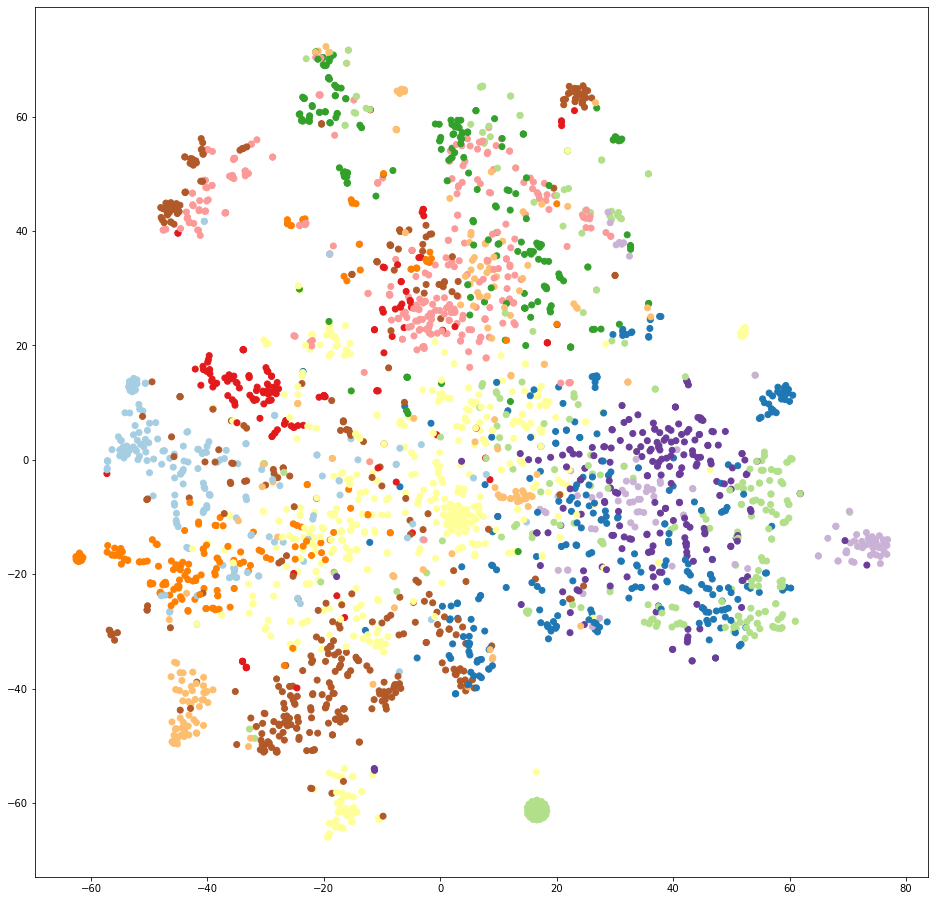

In [46]:
tsne(df_normas, vec30_model, lda_model, 'preprocessed_truncated')

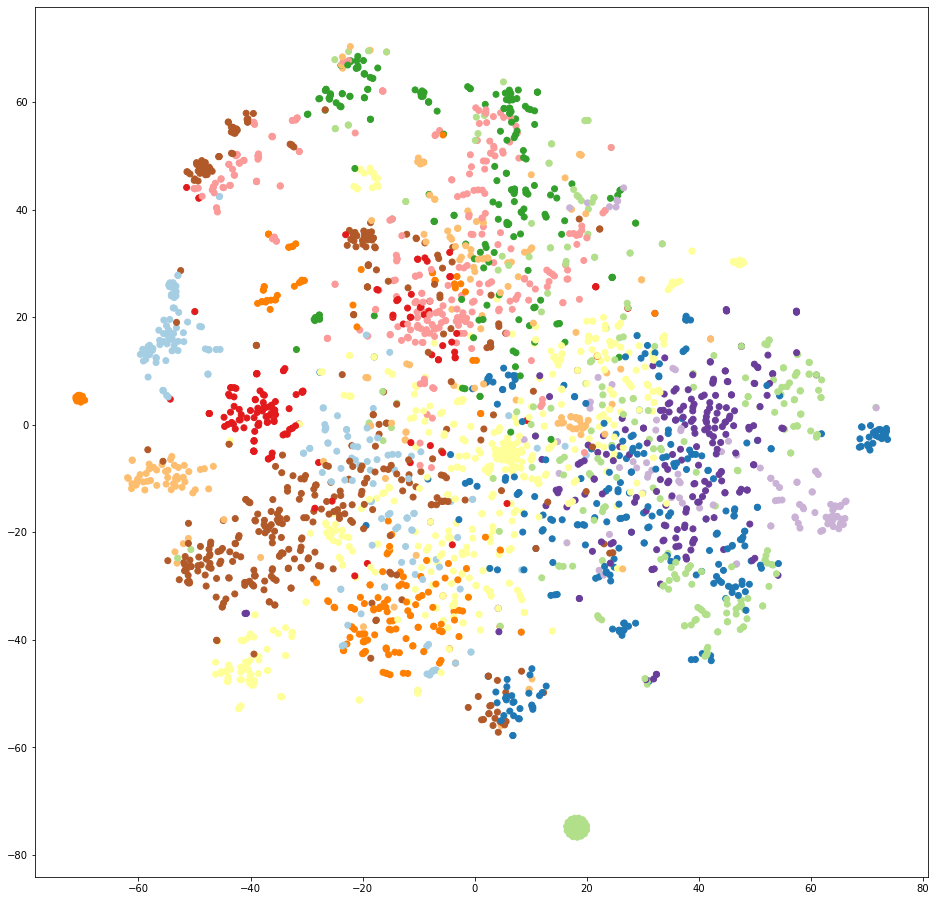

In [47]:
tsne(df_normas, vec50_model, lda_model, 'preprocessed_truncated')

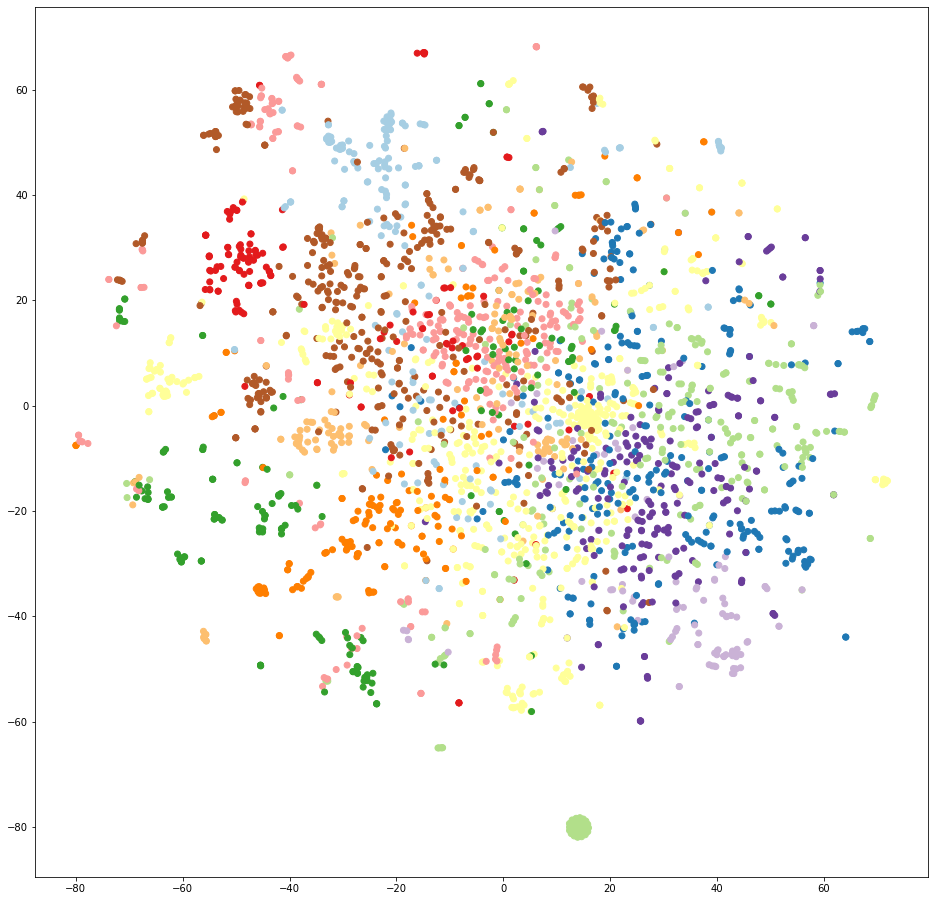

In [48]:
tsne(df_normas, vec100_model, lda_model, 'preprocessed_truncated')

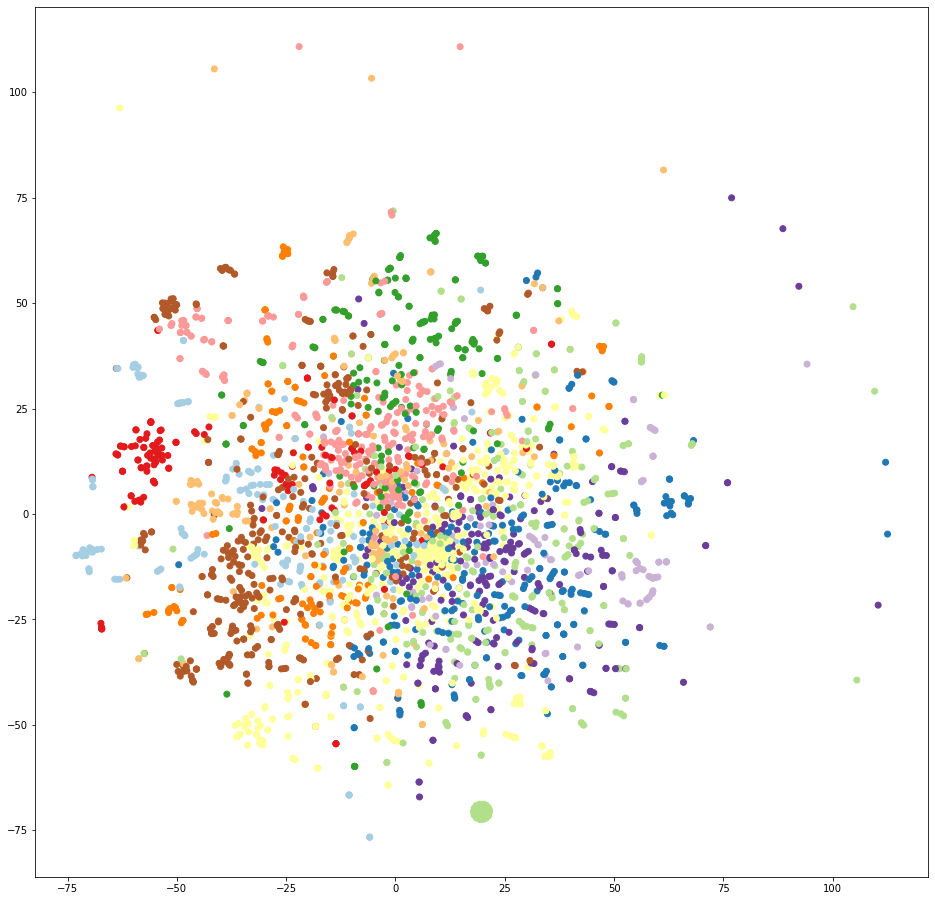

In [49]:
tsne(df_normas, vec200_model, lda_model, 'preprocessed_truncated')

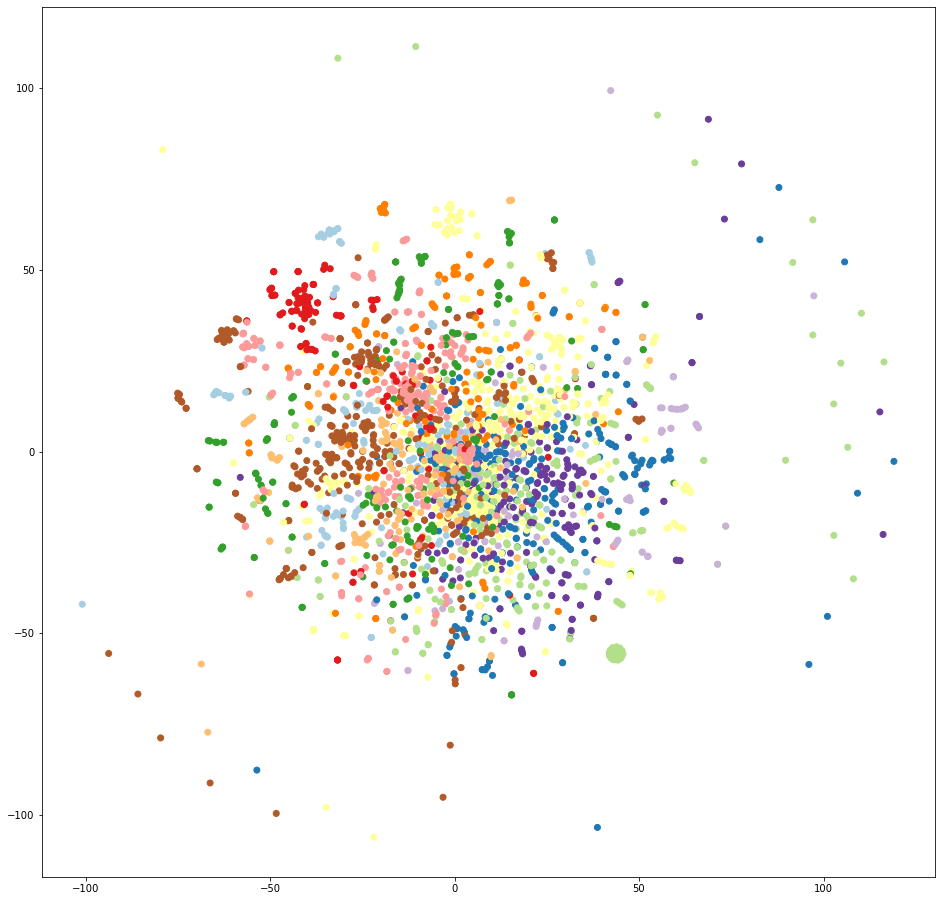

In [50]:
tsne(df_normas, vec300_model, lda_model, 'preprocessed_truncated')